In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Load the data
df = pd.read_excel('PARTIAL_Capstone_Data.xlsx', engine='openpyxl')

#Uncomment these when trying to predict current month death counts
#del df['Overdose_Rate_X100K']
#del df['crude_rate']
#del df['Rolling12_Deaths']

#Remove duplicate records
df = df.drop_duplicates()

In [2]:
df['unique_id'] = df['ST_ABBREV'].astype(str) + '_' + df['county_name'].astype(str) + '_' + df['PERIOD'].astype(str)
df['PERIOD'] = pd.to_datetime(df['PERIOD'].astype(str), format='%Y%m')
df['PERIOD_6m_ahead'] = df['PERIOD'] + pd.DateOffset(months=6)
df['unique_id_6m_ahead'] = df['ST_ABBREV'].astype(str) + '_' + df['county_name'].astype(str) + '_' + df['PERIOD_6m_ahead'].dt.strftime('%Y%m')

# Create lookup Series
deaths_lookup = df.set_index('unique_id')['Provisional Drug Overdose Deaths']
#deaths_lookup = df.set_index('unique_id')['crude_rate']

deaths_lookup = deaths_lookup[~deaths_lookup.index.duplicated(keep='first')]

# Map "6 months ahead" Deaths values
df['Deaths_6m_ahead'] = df['unique_id_6m_ahead'].map(deaths_lookup)

df_Prophet = df

# Remove rows for 2023 because of incomplete data.
df = df[df['PERIOD'] < '2023-01-01']
#df = df[df['PERIOD'] >= '2021-02-01']

# Only keep California
#df = df[df['ST_ABBREV'] == 'CA']

#Convert Period to string
df['PERIOD'] = df['PERIOD'].dt.strftime('%Y%m')

del df['unique_id_6m_ahead']
del df['PERIOD_6m_ahead']
del df['unique_id']

C:\Users\jjman\anaconda3\envs\JoseEnv\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
df

,county_name,state,Overdose_Rate_X100K,PERIOD,Provisional Drug Overdose Deaths,ST_ABBREV,Rolling12_Deaths,AGE1824_TOT,AGE1824_MALE,AGE1824_FEM,...,Avg4MonthSentiment_Count,Rolling5MonthSentiment_Count,High5MonthSentiment_Count,Low5MonthSentiment_Count,Avg5MonthSentiment_Count,Rolling6MonthSentiment_Count,High6MonthSentiment_Count,Low6MonthSentiment_Count,Avg6MonthSentiment_Count,Deaths_6m_ahead
0,ADAMS,Colorado,6.205214,202101,25,CO,144,48144,24945,23199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
1,ADAMS,Colorado,3.723128,202102,15,CO,151,48144,24945,23199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
2,ADAMS,Colorado,6.701631,202103,27,CO,164,48144,24945,23199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
3,ADAMS,Colorado,5.212380,202104,21,CO,169,48144,24945,23199,...,350.585253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0
4,ADAMS,Colorado,6.949840,202105,28,CO,175,48144,24945,23199,...,335.423963,1709.824885,368.129032,307.483871,341.964977,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,WORCESTER,Massachusetts,4.522936,202208,32,MA,363,82768,42101,40667,...,1433.016509,6701.066036,2152.206897,969.000000,1340.213207,7665.966036,2152.206897,964.900000,1277.661006,18.0
2290,WORCESTER,Massachusetts,3.392202,202209,24,MA,362,82768,42101,40667,...,1886.685595,8701.032703,2968.966667,1154.290323,1740.206541,9670.032703,2968.966667,969.000000,1611.672117,28.0
2291,WORCESTER,Massachusetts,5.370987,202210,38,MA,379,82768,42101,40667,...,2152.495004,9824.613348,2968.966667,1210.935484,1964.922670,10978.903671,2968.966667,1154.290323,1829.817278,19.0
2292,WORCESTER,Massachusetts,2.968177,202211,21,MA,379,82768,42101,40667,...,2363.036133,10663.080015,2968.966667,1210.935484,2132.616003,11877.713348,2968.966667,1210.935484,1979.618891,30.0


In [4]:

# Convert categorical variable(s) to dummy variables
df = pd.get_dummies(df, drop_first=True)

# After creating dummy variables in your training data
train_columns = df.columns

# For numerical columns
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].fillna(0, inplace=True)

#Remove any records without Rolling data
#df = df[df['Rolling2MonthDeaths'] >= 1 ]

#Remove any records without theft data
#df = df[df['Theft_Count'] >= 1 ]
        
# Define your features and target variable
X = df.drop('Deaths_6m_ahead', axis=1)
y = df['Deaths_6m_ahead']

### This is the wrong way of doing this for a time series.
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Assuming 'Period_202211' and 'Period_202212' are the columns for the test periods
test_column_1 = 'PERIOD_202211'
test_column_2 = 'PERIOD_202212'

# Create masks for selecting the test set
test_mask = (df[test_column_1] == 1) | (df[test_column_2] == 1)

# Split the data into training and testing sets
X_train = X[~test_mask]
X_test = X[test_mask]
y_train = y[~test_mask]
y_test = y[test_mask]

# Random Forest

Mean Squared Error: 68.4856660724896


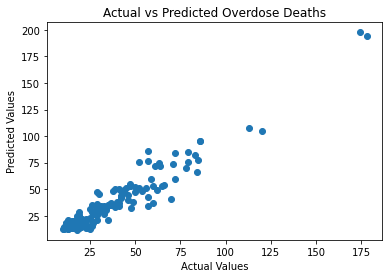

In [5]:
# Create a model
model = RandomForestRegressor(n_estimators=275, random_state=44, max_depth= 40, min_samples_leaf= 1, min_samples_split= 2)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Overdose Deaths')
plt.show()

# Best features Random Forest

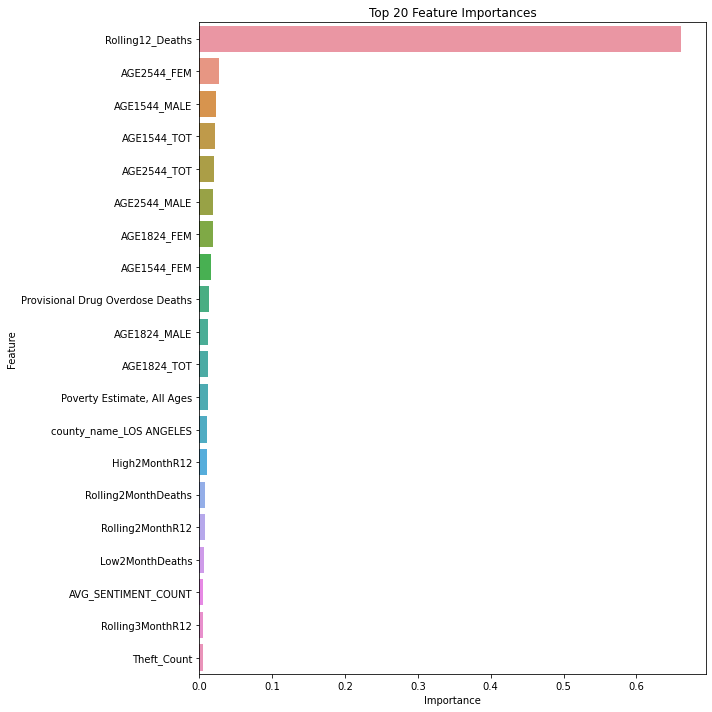

In [6]:
import seaborn as sns
# Retrieve and match feature importances with column names
feature_importances = model.feature_importances_
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features = features.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Focus on top 10 features
top_10_features = features.head(20)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


# Accuracy Random Forest

In [7]:
# Calculate Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

# Define the range values to check accuracy within
ranges = [1, 3, 5, 7, 9, 10, 15, 20]

# Loop through each range and calculate accuracy
for r in ranges:
    within_range = np.abs(predictions - y_test) <= r
    accuracy_within_range = np.mean(within_range)
    print(f'Accuracy within ±{r}: {accuracy_within_range:.2f}')

Root Mean Squared Error: 8.275606689088697
Mean Absolute Error: 5.912679738562091
R-squared: 0.9030280763975743
Accuracy within ±1: 0.13
Accuracy within ±3: 0.41
Accuracy within ±5: 0.53
Accuracy within ±7: 0.72
Accuracy within ±9: 0.78
Accuracy within ±10: 0.82
Accuracy within ±15: 0.92
Accuracy within ±20: 0.96


# XGBoost Model

Mean Squared Error: 75.43313458739185


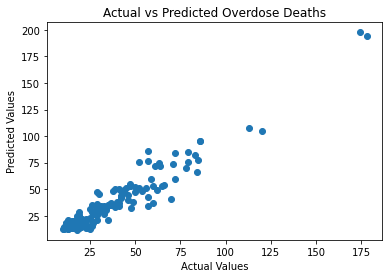

In [8]:
# Create a model using XGBRegressor
xgbmodel = xgb.XGBRegressor(n_estimators=125, random_state=44, max_depth=40, 
                         learning_rate=0.2, min_child_weight=2, 
                         subsample=0.8, colsample_bytree=.8, 
                         objective='reg:squarederror')

# Train the model
xgbmodel.fit(X_train, y_train)

# Make predictions
xgbpredictions = xgbmodel.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, xgbpredictions)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Overdose Deaths')
plt.show()

# Best Features XGBoost

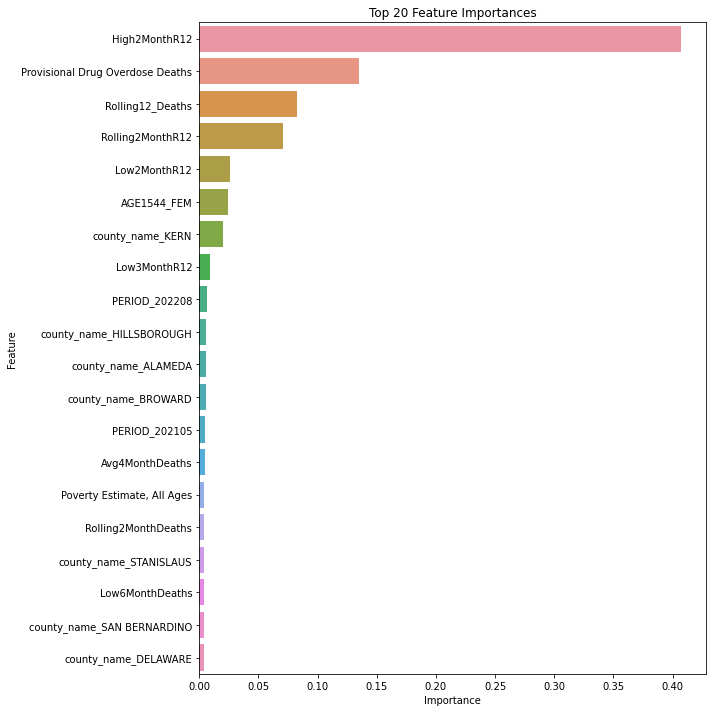

In [9]:
import seaborn as sns
# Retrieve and match feature importances with column names
feature_importances = xgbmodel.feature_importances_
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features = features.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Focus on top 10 features
top_10_features = features.head(20)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


# Accuracy XGBoost

In [10]:
# Calculate Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, xgbpredictions))
print(f'Root Mean Squared Error: {rmse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, xgbpredictions)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, xgbpredictions)
print(f'R-squared: {r2}')

# Define the range values to check accuracy within
ranges = [1, 3, 5, 7, 9, 10, 13, 20]

# Loop through each range and calculate accuracy
for r in ranges:
    within_range = np.abs(xgbpredictions - y_test) <= r
    accuracy_within_range = np.mean(within_range)
    print(f'Accuracy within ± {r}: {accuracy_within_range:.2f}')

Root Mean Squared Error: 8.685225074077922
Mean Absolute Error: 6.30381180920632
R-squared: 0.8931908443942488
Accuracy within ± 1: 0.12
Accuracy within ± 3: 0.35
Accuracy within ± 5: 0.56
Accuracy within ± 7: 0.67
Accuracy within ± 9: 0.81
Accuracy within ± 10: 0.83
Accuracy within ± 13: 0.88
Accuracy within ± 20: 0.95


# Facebook PROPHET Model

In [11]:
import pandas as pd
from prophet import Prophet

# Assuming df is your original DataFrame and has been loaded already
df_Prophet_run = df_Prophet[df_Prophet['county_name']=='ALAMEDA']
#df_Prophet = df_Prophet[df_Prophet['PERIOD']!='2021-01-01']
# Convert 'PERIOD' to datetime format if not already done
#df_Prophet['PERIOD'] = pd.to_datetime(df_Prophet['PERIOD'].astype(str), format='%Y%m')

# Prepare the DataFrame for Prophet, including the regressor
prophet_df = df_Prophet_run[['PERIOD', 'Provisional Drug Overdose Deaths', 'Rolling12_Deaths','AGE2544_FEM']].copy()
prophet_df.rename(columns={'PERIOD': 'ds', 'Provisional Drug Overdose Deaths': 'y'}, inplace=True)

# Initialize the Prophet model
m = Prophet()


18:00:57 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing


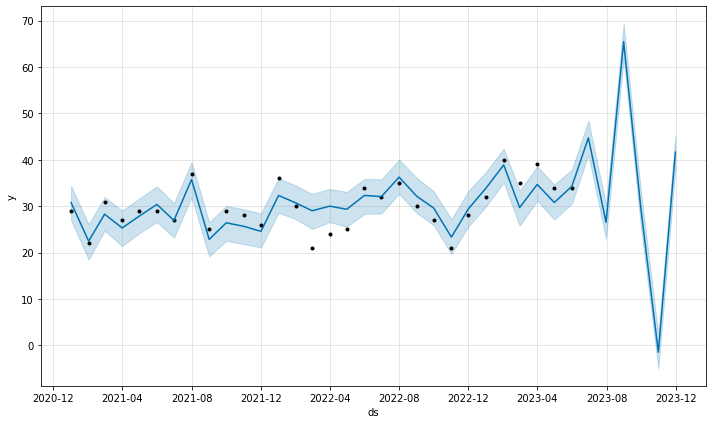

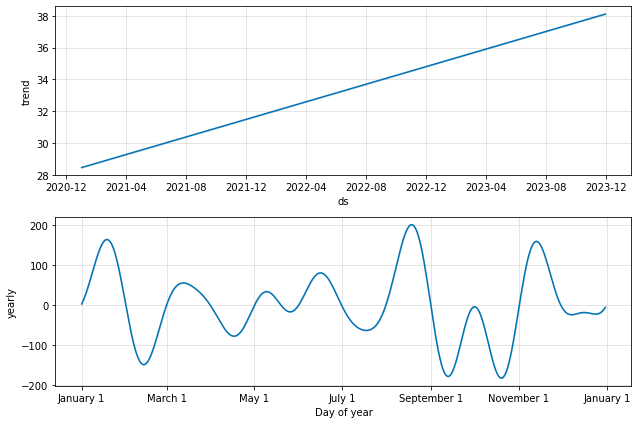

In [12]:
# Add the '12monthRolling_Deaths' as an additional regressor
#m.add_regressor('Rolling12_Deaths')
#m.add_regressor('AGE2544_FEM')

# Fit the model with your DataFrame
m.fit(prophet_df)

# Create a DataFrame for future predictions
# Note: You must also provide future values for the '12monthRolling_Deaths' regressor in the future DataFrame
future_periods = 6  # Define the number of periods you want to forecast
future = m.make_future_dataframe(periods=future_periods, freq='M')

# For demonstration, let's assume the future values stay constant as the last known value (this is likely not realistic and should be adjusted)
#last_known_value1 = prophet_df['Rolling12_Deaths'].iloc[-1]
#future['Rolling12_Deaths'] = last_known_value1

#last_known_value2 = prophet_df['AGE2544_FEM'].iloc[-1]
#future['AGE2544_FEM'] = last_known_value2


# Make predictions including the regressor
forecast = m.predict(future)

# Plot the forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


Accuracy within ±1 deaths: 16.67%
Accuracy within ±2 deaths: 53.33%
Accuracy within ±3 deaths: 76.67%
Accuracy within ±4 deaths: 83.33%
Accuracy within ±5 deaths: 90.00%
Accuracy within ±7 deaths: 96.67%
Accuracy within ±9 deaths: 100.00%
Accuracy within ±10 deaths: 100.00%
Accuracy within ±13 deaths: 100.00%
Accuracy within ±20 deaths: 100.00%


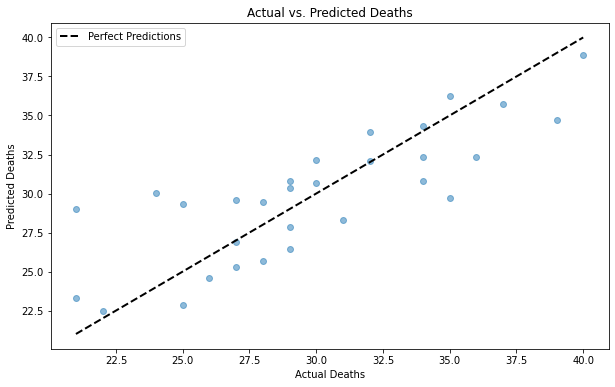

In [13]:
# Assuming 'df' contains the actual 'y' values and a 'ds' column for dates
results = forecast[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='inner')

tolerance_levels = [1, 2, 3, 4, 5, 7, 9, 10, 13, 20]

for tol in tolerance_levels:
    results[f'within_{tol}'] = abs(results['yhat'] - results['y']) <= tol
    accuracy = results[f'within_{tol}'].mean() * 100  # Convert to percentage
    print(f"Accuracy within ±{tol} deaths: {accuracy:.2f}%")
    
# Creating the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(results['y'], results['yhat'], alpha=0.5)  # Adjust alpha for point transparency

# Adding plot labels and title
plt.xlabel('Actual Deaths')
plt.ylabel('Predicted Deaths')
plt.title('Actual vs. Predicted Deaths')

# Optionally, add a line of best fit or y=x line to indicate perfect predictions
import numpy as np
line_start = min(results['y'].min(), results['yhat'].min())
line_end = max(results['y'].max(), results['yhat'].max())
plt.plot([line_start, line_end], [line_start, line_end], 'k--', lw=2, label='Perfect Predictions')
plt.legend()

# Show the plot
plt.show()



In [14]:
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
print(f'RMSE: {rmse}')

RMSE: 2.919290700482586


# New Data Section

### This is where we will upload new data (in May when it's released) to predict out further into the future

In [15]:
# Load new data
new_data = pd.read_excel('predictions_before.xlsx', engine='openpyxl')

# Preprocess the new data in the same way as the training data
new_data = pd.get_dummies(new_data, drop_first=True)

# For numerical columns
#new_data[col].fillna(new_data[col].mean(), inplace=True)
for col in new_data.columns:
    if new_data[col].dtype == 'float64' or new_data[col].dtype == 'int64':
        new_data[col].fillna(0, inplace=True)

# Add missing columns of zeros
missing_cols = set(train_columns) - set(new_data.columns)
for c in missing_cols:
    new_data[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
new_data = new_data[train_columns]

# Separate features from target
X_new = new_data.drop('Provisional Drug Overdose Deaths', axis=1)
y_new = new_data['Provisional Drug Overdose Deaths']


# Use the model to make predictions on the new data
new_predictions = model.predict(X_new)

# If you want to see the predicted values
print(new_predictions)


FileNotFoundError: [Errno 2] No such file or directory: 'predictions_before.xlsx'

In [ ]:
# Create a DataFrame with the desired columns and predictions
output_df = pd.DataFrame({
    'ID': new_data['ID'],
    'Provisional Drug Overdose Deaths': new_predictions
})

# Write the DataFrame to an Excel file
output_df.to_excel('Predictions_After.xlsx', index=False)

# Appendix

## Used to find best hyperparameters for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [75, 100, 300, 500, 700],
    'max_depth': [None, 10, 35],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=44),
                           param_grid=param_grid,
                           cv=5,  # Number of folds in cross-validation
                           scoring='neg_mean_squared_error',
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_predictions = grid_search.best_estimator_.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test, best_predictions)
print(f'Mean Squared Error of the best model: {best_mse}')
